In [1]:
from apippy.api import get_price

res = get_price(start_date="20160201", end_date="20250501", type = 'index')

In [2]:
# test = get_price(start_date='20230101', end_date='20240501', type = 'future')

# 中证1000

000852

# 沪深300

000300

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from empyrical import max_drawdown, alpha_beta


# # Helper function for Max Drawdown (needed for metrics)
# def max_drawdown(returns):
#     """
#     Calculates the maximum drawdown from a series of returns.

#     Args:
#         returns (pd.Series): Series of daily returns.

#     Returns:
#         float: Maximum drawdown as a negative percentage.
#     """
#     # Calculate cumulative returns
#     cumulative = (1 + returns).cumprod()
#     # Calculate peak cumulative return up to each point
#     peak = cumulative.expanding().max()
#     # Calculate drawdown from peak
#     drawdown = (cumulative - peak) / peak
#     # Find the maximum drawdown
#     max_dd = drawdown.min()
#     return max_dd

# Helper function to calculate backtesting metrics
def calculate_metrics(returns):
    """
    Calculates common backtesting metrics.

    Args:
        returns (pd.Series): Series of daily returns.

    Returns:
        dict: Dictionary containing calculated metrics.
    """
    # Ensure returns are not all NaN or zero before calculating metrics
    if returns.isnull().all() or returns.sum() == 0:
         return {
            'Total Return': 0.0,
            'Annualized Return': 0.0,
            'Volatility': 0.0,
            'Sharpe Ratio': 0.0,
            'Max Drawdown': 0.0
         }

    total_return = (1 + returns).prod() - 1 # Correct total return calculation
    # Avoid division by zero or issues with short periods
    if len(returns) == 0:
        annualized_return = 0
    else:
         annualized_return = (1 + total_return) ** (252 / len(returns)) - 1  # Annualize based on actual length

    volatility = returns.std() * np.sqrt(252)  # Annualized volatility
    sharpe = annualized_return / volatility if volatility != 0 else 0 # Sharpe Ratio (assuming 0 risk-free rate)
    max_dd = max_drawdown(returns)  # Maximum Drawdown

    return {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd
    }


def run_backtest(start_date, etf_data_0, etf_data_1, signal_data, end_date = None, verbose = 3):
    """
    Runs a backtest switching between two ETFs based on a signal.

    Args:
        start_date (str or datetime): The start date for the backtest.
        etf_data_0 (pd.DataFrame): DataFrame for the first ETF (long when signal > 0).
                                  Must contain 'date', 'prev_close', 'close'.
        etf_data_1 (pd.DataFrame): DataFrame for the second ETF (long when signal < 0).
                                  Must contain 'date', 'prev_close', 'close'.
        signal_data (pd.Series or dict): Signal data, indexed by date.
                                        Positive value for ETF0, negative for ETF1, 0 for cash.
                                        Assumed to be available *before* market prev_close.
    Returns:
        tuple: (combined_df, strategy_metrics, benchmark_metrics)
               combined_df: DataFrame with all data and backtest results.
               strategy_metrics: Dictionary of strategy performance metrics.
               benchmark_metrics: Dictionary of benchmark performance metrics.
    """
    start_date = pd.to_datetime(start_date)

    # --- Data Preparation ---

    # Process ETF 0 data
    etf0_df = etf_data_0.copy()
    etf0_df['date'] = pd.to_datetime(etf0_df['date'])
    etf0_df.set_index('date', inplace=True)
    etf0_df.rename(columns={'prev_close': 'etf0_prev_close', 'close': 'etf0_close'}, inplace=True)
    # 这里删去了部分信息
    etf0_df = etf0_df[['etf0_prev_close', 'etf0_close']] # Keep only necessary columns

    # Process ETF 1 data
    etf1_df = etf_data_1.copy()
    etf1_df['date'] = pd.to_datetime(etf1_df['date'])
    etf1_df.set_index('date', inplace=True) # Fix: changed variable name
    etf1_df.rename(columns={'prev_close': 'etf1_prev_close', 'close': 'etf1_close'}, inplace=True)
    etf1_df = etf1_df[['etf1_prev_close', 'etf1_close']] # Keep only necessary columns

    # Process signal data
    if isinstance(signal_data, pd.Series):
        signal_df = pd.DataFrame({'date': signal_data.index, 'signal': signal_data.values})
    else: # Assume dict or similar structure
        signal_df = pd.DataFrame(signal_data.items(), columns=['date', 'signal'])
    signal_df['date'] = pd.to_datetime(signal_df['date'])
    signal_df.set_index('date', inplace=True)

    # Combine dataframes
    # Use outer join to keep all dates from ETFs and signal, then fill missing prices if needed,
    # or use inner join if you only want dates where all data is present.
    # Inner join is safer to avoid NaN price issues in returns.
    combined = etf0_df.join(etf1_df, how='inner').join(signal_df, how='left') # Inner join on ETFs first

    # Filter data from start date
    combined = combined[combined.index >= start_date].copy()
    if end_date is not None:
        combined = combined[combined.index <= pd.to_datetime(end_date)].copy()
    # Handle potential NaNs after joins and filtering
    combined.dropna(subset=['etf0_prev_close', 'etf0_close', 'etf1_prev_close', 'etf1_close'], inplace=True)

    # Forward fill signal (use the most recent signal)
    combined['signal'] = combined['signal'].ffill()
    
    # Handle potential NaNs in signal *at the beginning* after ffill
    # If the first signal is NaN after ffill, assume 0 position
    combined['signal'] = combined['signal'].fillna(0)


    # --- Strategy Logic ---

    # Calculate prev_close-to-Close returns for both ETFs on each day
    # This matches the original code's return calculation method
    
    # 好像有点问题
    # data['etf0_daily_return'] = data['etf0_close'] / data['etf0_prev_close'] - 1
    # data['etf1_daily_return'] = data['etf1_close'] / data['etf1_prev_close'] - 1

    combined['etf0_daily_return'] = combined['etf0_close'].pct_change().fillna(0)
    combined['etf1_daily_return'] = combined['etf1_close'].pct_change().fillna(0)
    # Determine the position for the *next* day based on the *current* day's signal
    # We assume signal is available End-of-Day and trades are executed at next day's Open
    combined['shifted_signal'] = combined['signal'].shift(1).fillna(0) # Position based on previous day's signal
    # 处理signal 到[-1,1]
    combined['shifted_signal'] = np.where(combined['shifted_signal'] >=0, 1, -1)
    # Calculate strategy daily return based on shifted signal
    # If shifted_signal >= 0: long ETF0 (get etf0_daily_return)
    # If shifted_signal < 0: long ETF1 (get etf1_daily_return)
    conditions = [
        combined['shifted_signal'] > 0,
        combined['shifted_signal'] < 0,
    ]
    choices = [
        combined['etf0_daily_return'],
        combined['etf1_daily_return'],
    ]
    combined['strategy_daily_return'] = np.select(conditions, choices, default=0)
    
    # 这里假设手续费是0.001
    # 计算换仓次数（信号变动次数）
    combined['signal_change'] = combined['shifted_signal'].diff().ne(0).astype(int)

    # --- Performance Calculation ---

    # Calculate cumulative returns
    # Start cumulative return from 1 before multiplying by (1 + daily_return)


    combined['strategy_daily_return'] = (1 + combined['strategy_daily_return']) * np.where(combined['signal_change'] == 1, (1 - 0.001)**2, 1)-1
    combined['strategy_cumulative'] = (1 + combined['strategy_daily_return']).cumprod() - 1

    # Calculate benchmark cumulative return (Buy and Hold ETF0 using Close prices)
    # Use Close-to-Close for a standard benchmark
    combined['benchmark_daily_return'] = combined['etf0_close'].pct_change().fillna(0)
    combined['benchmark_cumulative'] = (1 + combined['benchmark_daily_return']).cumprod() - 1
    # Correct the benchmark cumulative start point if needed - ensure it starts at 0 or the correct base
    # A simple way is price relative to the first price in the period:
    if not combined['etf0_close'].empty:
         combined['benchmark_cumulative'] = combined['etf0_close'] / combined['etf0_close'].iloc[0] - 1
    else:
         combined['benchmark_cumulative'] = 0.0

    combined['profit_cumulative'] = combined['strategy_cumulative'] - combined['benchmark_cumulative']

    # --- Plotting 1---
    if verbose >= 2:
        plt.figure(figsize=(12, 6))

        # Plot strategy cumulative return
        plt.plot(combined.index, combined['strategy_cumulative'], label='Strategy')
        plt.plot(combined.index, combined['profit_cumulative'], label='Profit (Strategy - Benchmark)', linestyle='--')
        if verbose >= 3:
        # Highlight different positions with colors
        # signale 是1绿色买中证1000，signal是-1 红色买沪深300
            for i in range(len(combined) - 1):
                # if combined['shifted_signal'].iloc[i] == 0:
                #     plt.axvspan(combined.index[i], combined.index[i + 1], color='gray', alpha=0.2, label='Cash Position' if i == 0 else None)
                if combined['shifted_signal'].iloc[i] > 0:
                    plt.axvspan(combined.index[i], combined.index[i + 1], color='green', alpha=0.2)
                elif combined['shifted_signal'].iloc[i] < 0:
                    plt.axvspan(combined.index[i], combined.index[i + 1], color='red', alpha=0.2)

        # Plot benchmark cumulative return
        plt.plot(combined.index, combined['benchmark_cumulative'], label='Benchmark (Buy & Hold ETF0)')
        # plt.plot(combined.index, combined['best_possible_cumulative'], label='Best Possible Cumulative Return', linestyle='--')
        plt.legend()
        plt.title('Strategy vs Benchmark Cumulative Return')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')
        plt.grid(True)
        plt.show()
    # --- Metrics Calculation ---

    # Exclude the first day's return for metrics calculation as position is based on shifted signal
    # This is often done, but can be debated. Let's calculate metrics on the full 'strategy_daily_return' series
    # that was used for cumulative returns.
    # 计算超额收益率
    strategy_metrics = calculate_metrics(combined['strategy_daily_return'])
    benchmark_metrics = calculate_metrics(combined['benchmark_daily_return']) # Use the pct_change series for benchmark metrics
    if verbose >= 1:
        print("\n--- Strategy Metrics ---")
        for metric, value in strategy_metrics.items():
            print(f"{metric}: {value:.4f}")

        print("\n--- Benchmark Metrics (Buy & Hold ETF0) ---")
        for metric, value in benchmark_metrics.items():
            print(f"{metric}: {value:.4f}")


    return combined, strategy_metrics, benchmark_metrics



In [4]:
# 中证1000
etf0_data = res.loc[res['order_book_id'] == '000852.XSHG'].sort_values('date')
# 沪深300
etf1_data = res.loc[res['order_book_id'] == '000300.XSHG'].sort_values('date')



In [5]:
def signal_generation(etf0_data, volatility_window = 10, volatility_threshold = 0.015,
                       short_window = 5, long_window = 20, bollinger_window = 20,
                       weights = [0.4, 0.4, 0.2]):

    # --- Combine Multiple Strategies ---

    # 1. 基于波动率的信号
    # volatility_window = 10
    # volatility_threshold = 0.015
    etf0_data['returns'] = etf0_data['close'].pct_change()
    etf0_data['volatility_signal'] = etf0_data['returns'].rolling(window=volatility_window).std().apply(
        lambda x: 1 if x > volatility_threshold else -1
    )

    # 2. 基于均线交叉的信号

    # short_window = 5
    # long_window = 20
    etf0_data['short_ma'] = etf0_data['close'].rolling(window=short_window).mean()
    etf0_data['long_ma'] = etf0_data['close'].rolling(window=long_window).mean()
    etf0_data['ma_signal'] = etf0_data.apply(
        lambda row: 1 if row['short_ma'] > row['long_ma'] else 
                    (-1 if row['short_ma'] < row['long_ma'] else 0), axis=1
    )
    # 只做突破
    # etf0_data['ma_signal'] = etf0_data.apply(
    #     lambda row: 1 if row['short_ma'] > row['long_ma'] else 0, axis=1
    # )

    # 4. 基于布林带的信号
    # bollinger_window = 20
    etf0_data['bollinger_mid'] = etf0_data['close'].rolling(window=bollinger_window).mean()
    etf0_data['bollinger_std'] = etf0_data['close'].rolling(window=bollinger_window).std()
    etf0_data['bollinger_upper'] = etf0_data['bollinger_mid'] + 2 * etf0_data['bollinger_std']
    etf0_data['bollinger_lower'] = etf0_data['bollinger_mid'] - 2 * etf0_data['bollinger_std']
    etf0_data['bollinger_signal'] = etf0_data.apply(
        lambda row: -1 if row['close'] < row['bollinger_lower'] else 
                    (1 if row['close'] > row['bollinger_upper'] else 0), axis=1
    )

    # --- Combine Signals ---
    # 加权组合信号
    # signal_data = (
    #     weights[0] * etf0_data['volatility_signal'] +
    #     weights[1] * etf0_data['ma_signal'] +
    #     weights[2] * etf0_data['bollinger_signal']
    # )
    signal_keys = ['volatility_signal', 'ma_signal', 'bollinger_signal']

    signal_values = [etf0_data[key] for key in signal_keys]
    signal_data = sum(w * s for w, s in zip(weights, signal_values))
    # 将信号数据存储为 pandas.Series
    signal_data.index = etf0_data['date']
    signal_data = pd.Series(signal_data)

    return signal_data


In [6]:
signal_data = signal_generation(etf0_data)

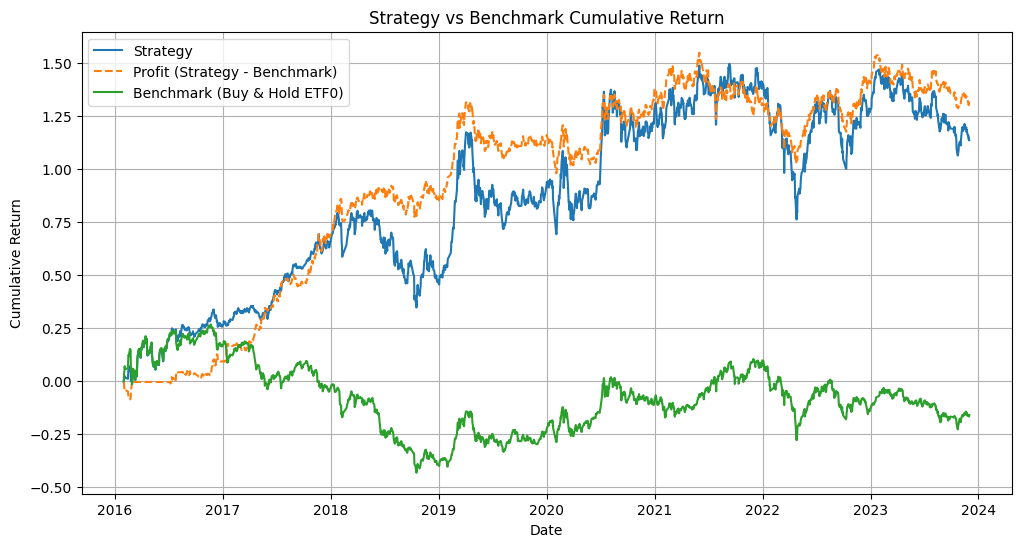


--- Strategy Metrics ---
Total Return: 1.1364
Annualized Return: 0.1056
Volatility: 0.2089
Sharpe Ratio: 0.5057
Max Drawdown: -0.2940

--- Benchmark Metrics (Buy & Hold ETF0) ---
Total Return: -0.1594
Annualized Return: -0.0227
Volatility: 0.2297
Sharpe Ratio: -0.0989
Max Drawdown: -0.5511


In [20]:
backtest_results, strat_metrics, bench_metrics = run_backtest(
    start_date='2016-01-01',
    end_date = '2023-12-01',
    etf_data_0=etf0_data,
    etf_data_1=etf1_data,
    signal_data=signal_data,
    verbose=2
)

In [21]:
import optuna
# from tqdm.notebook import tqdm
def objective(trial):
    """
    Objective function for Optuna optimization.
    """
    # Define hyperparameters to optimize
    volatility_window = trial.suggest_int('volatility_window', 5, 20)
    volatility_threshold = trial.suggest_float('volatility_threshold', 0.0075, 0.0125)
    short_window = trial.suggest_int('short_window', 5, 20)
    long_window = trial.suggest_int('long_window', 20, 60)
    bollinger_window = trial.suggest_int('bollinger_window', 10, 30)
    weights = [
        trial.suggest_float('weight_1', 0.1, 0.6),
        trial.suggest_float('weight_2', 0.1, 0.6),
        trial.suggest_float('weight_3', 0.1, 0.6)
    ]
    # Normalize weights to sum to 1
    weights = [w / sum(weights) for w in weights]
    # Generate signals with the current hyperparameters
    signal_data = signal_generation(
        etf0_data,
        volatility_window=volatility_window,
        volatility_threshold=volatility_threshold,
        short_window=short_window,
        long_window=long_window,
        bollinger_window=bollinger_window,
        weights=weights
    )

    # Run backtest with the generated signals
    _, strategy_metrics, _ = run_backtest(
        start_date='2017-01-01',
        end_date='2023-12-01',
        etf_data_0=etf0_data,
        etf_data_1=etf1_data,
        signal_data=signal_data,
        verbose = False
    )

    # Return the Sharpe ratio as the objective to maximize
    return strategy_metrics['Sharpe Ratio']

# Create a study object
study = optuna.create_study(direction='maximize')
# Optimize the objective function
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=500, show_progress_bar=True)

  0%|          | 0/500 [00:00<?, ?it/s]

In [23]:
print("Best trial:")
best_trial = study.best_trial
print(f"Value: {best_trial.value}")
print(f"Logit Params: {best_trial.params}")

Best trial:
Value: 0.37732923953778547
Logit Params: {'volatility_window': 16, 'volatility_threshold': 0.012420379887711856, 'short_window': 15, 'long_window': 37, 'bollinger_window': 29, 'weight_1': 0.4605654184028599, 'weight_2': 0.4306500466278337, 'weight_3': 0.10940653813781083}


In [24]:
params = best_trial.params
params['weights'] = [
    params['weight_1'],
    params['weight_2'],
    params['weight_3']
]
del params['weight_1'], params['weight_2'], params['weight_3']

In [270]:
best_trial.params

{'volatility_window': 16,
 'volatility_threshold': 0.007714155833003038,
 'short_window': 10,
 'long_window': 39,
 'bollinger_window': 13,
 'weight_1': 0.1462716190338394,
 'weight_2': 0.43402500226244434,
 'weight_3': 0.21195676672771935}

# 训练集

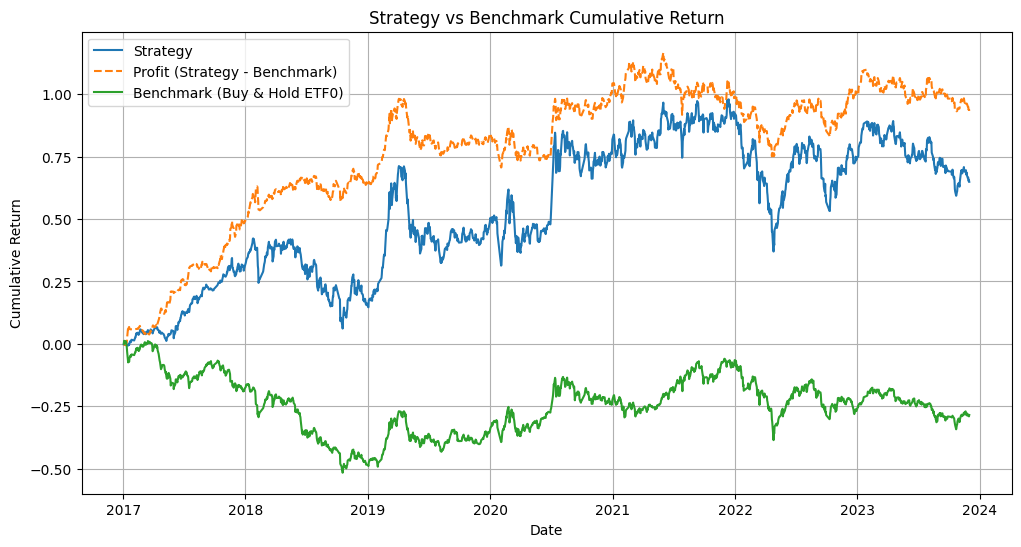


--- Strategy Metrics ---
Total Return: 0.6490
Annualized Return: 0.0779
Volatility: 0.2063
Sharpe Ratio: 0.3773
Max Drawdown: -0.3079

--- Benchmark Metrics (Buy & Hold ETF0) ---
Total Return: -0.2843
Annualized Return: -0.0489
Volatility: 0.2244
Sharpe Ratio: -0.2179
Max Drawdown: -0.5214


In [25]:
signal_data = signal_generation(**best_trial.params, etf0_data=etf0_data)
backtest_results, strat_metrics, bench_metrics = run_backtest(
    start_date='2017-01-01',
    end_date = '2023-12-01',
    etf_data_0=etf0_data,
    etf_data_1=etf1_data,
    signal_data=signal_data,
    verbose = 2
)

In [279]:
backtest_results['signal_change'].sum()


35

# 测试集

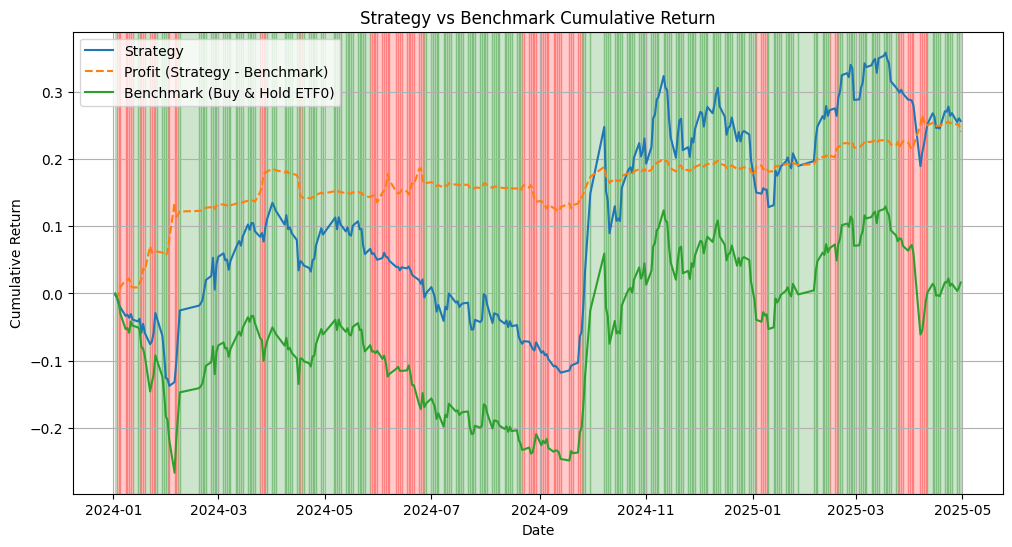


--- Strategy Metrics ---
Total Return: 0.2566
Annualized Return: 0.1971
Volatility: 0.2878
Sharpe Ratio: 0.6846
Max Drawdown: -0.2227

--- Benchmark Metrics (Buy & Hold ETF0) ---
Total Return: 0.0163
Annualized Return: 0.0128
Volatility: 0.3280
Sharpe Ratio: 0.0390
Max Drawdown: -0.2667


In [26]:
signal_data = signal_generation(**best_trial.params, etf0_data=etf0_data)
backtest_results, strat_metrics, bench_metrics = run_backtest(
    start_date='2024-01-01',
    # end_date = '20-12-01',
    etf_data_0=etf0_data,
    etf_data_1=etf1_data,
    signal_data=signal_data,
    verbose = 3
)

In [14]:
backtest_results['strategy_daily_return']

date
2024-01-02   -0.007506
2024-01-03   -0.004373
2024-01-04   -0.009249
2024-01-05   -0.005360
2024-01-08   -0.012933
                ...   
2025-04-24   -0.010712
2025-04-25    0.003213
2025-04-28   -0.010514
2025-04-29    0.004479
2025-04-30   -0.003190
Name: strategy_daily_return, Length: 320, dtype: float64